In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, QuantileTransformer

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [3]:
import warnings

In [4]:
import tensorflow as tf
import tensorflow.keras as k

In [5]:
def read_data():
    df = pd.read_parquet("../dataset.parquet")
    categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
    feature_columns = [
        'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
        'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 
        'fst_sale_in_black_friday_days', 'snd_sale_in_black_friday_days'
    ]

    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    df = df.loc[df.waiting_time > 0]

    features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
    X = df.loc[:, features].copy()
    y = df.loc[:, 'has_second_sale_within_year'].copy()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    qt = QuantileTransformer()
    qt.fit(X_train.loc[:, ["age", "gmv"]])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
        X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = read_data()

In [7]:
n_examples, shape_dim = X_train.shape

In [9]:
inputs = k.Input(shape=(shape_dim,))

pos_encoder = k.models.Sequential([
    k.layers.Dense(128, activation='selu'),
    k.layers.BatchNormalization(),
    k.layers.Dense(32, activation='selu'),
    k.layers.BatchNormalization()
])

pos_decoder = k.models.Sequential([
    k.layers.Dense(128, activation='selu'),
    k.layers.BatchNormalization(),
    k.layers.Dense(shape_dim, activation='sigmoid')
])

pos_ae = k.models.Model(inputs=inputs, outputs=pos_decoder(pos_encoder(inputs)))
pos_ae.compile(
    optimizer=k.optimizers.Nadam(), 
    loss='binary_crossentropy', 
    metrics=["mae"]
)

pos_ae.fit(
    X_train.loc[y_train == 0], 
    X_train.loc[y_train == 0], 
    validation_split=0.1,
    batch_size=512,
    epochs=10
)

Train on 577499 samples, validate on 64167 samples
Epoch 1/10
577499/577499 [==============================] - 11s 20us/sample - loss: 0.0707 - mae: 0.0465 - val_loss: 0.0138 - val_mae: 0.0022
Epoch 2/10
577499/577499 [==============================] - 11s 19us/sample - loss: 0.0131 - mae: 0.0015 - val_loss: 0.0127 - val_mae: 0.0010
Epoch 3/10
577499/577499 [==============================] - 11s 19us/sample - loss: 0.0126 - mae: 9.6733e-04 - val_loss: 0.0125 - val_mae: 8.3383e-04
Epoch 4/10
577499/577499 [==============================] - 11s 19us/sample - loss: 0.0125 - mae: 8.1975e-04 - val_loss: 0.0124 - val_mae: 7.4667e-04
Epoch 5/10
577499/577499 [==============================] - 11s 18us/sample - loss: 0.0125 - mae: 7.2649e-04 - val_loss: 0.0124 - val_mae: 6.2411e-04
Epoch 6/10
577499/577499 [==============================] - 11s 18us/sample - loss: 0.0124 - mae: 6.2685e-04 - val_loss: 0.0124 - val_mae: 5.3258e-04
Epoch 7/10
577499/577499 [==============================] - 11s 1

In [10]:
inputs = k.Input(shape=(shape_dim,))

neg_encoder = k.models.Sequential([
    k.layers.Dense(128, activation='selu'),
    k.layers.BatchNormalization(),
    k.layers.Dense(32, activation='selu'),
    k.layers.BatchNormalization()
])

neg_decoder = k.models.Sequential([
    k.layers.Dense(128, activation='selu'),
    k.layers.BatchNormalization(),
    k.layers.Dense(shape_dim, activation='sigmoid')
])

neg_ae = k.models.Model(inputs=inputs, outputs=neg_decoder(neg_encoder(inputs)))
neg_ae.compile(
    optimizer=k.optimizers.Nadam(), 
    loss='binary_crossentropy', 
    metrics=["mae"]
)

neg_ae.fit(
    X_train.loc[y_train == 1], 
    X_train.loc[y_train == 1], 
    validation_split=0.1,
    batch_size=512,
    epochs=10
)

Train on 195819 samples, validate on 21758 samples
Epoch 1/10
195819/195819 [==============================] - 4s 21us/sample - loss: 0.1776 - mae: 0.1286 - val_loss: 0.0306 - val_mae: 0.0178
Epoch 2/10
195819/195819 [==============================] - 4s 19us/sample - loss: 0.0191 - mae: 0.0069 - val_loss: 0.0168 - val_mae: 0.0050
Epoch 3/10
195819/195819 [==============================] - 3s 16us/sample - loss: 0.0150 - mae: 0.0031 - val_loss: 0.0144 - val_mae: 0.0026
Epoch 4/10
195819/195819 [==============================] - 4s 18us/sample - loss: 0.0139 - mae: 0.0020 - val_loss: 0.0136 - val_mae: 0.0017
Epoch 5/10
195819/195819 [==============================] - 4s 19us/sample - loss: 0.0134 - mae: 0.0015 - val_loss: 0.0132 - val_mae: 0.0013
Epoch 6/10
195819/195819 [==============================] - 4s 20us/sample - loss: 0.0131 - mae: 0.0012 - val_loss: 0.0130 - val_mae: 0.0011
Epoch 7/10
195819/195819 [==============================] - 4s 20us/sample - loss: 0.0129 - mae: 0.0011

In [11]:
X_train_pos = pos_encoder.predict(X_train)
X_train_neg = neg_encoder.predict(X_train)
X_train_rec = pd.np.c_[X_train_pos, X_train_neg]

In [12]:
X_test_pos = pos_encoder.predict(X_test)
X_test_neg = neg_encoder.predict(X_test)
X_test_rec = pd.np.c_[X_test_pos, X_test_neg]

In [51]:
delta_train = pd.np.abs(X_train_pos - X_train_neg).mean(axis=1)

In [52]:
pd.Series(delta_train).describe()

count    859243.000000
mean          1.128097
std           0.169506
min           0.578930
25%           1.004107
50%           1.113032
75%           1.233748
max           2.194006
dtype: float64

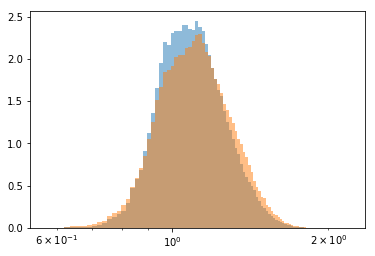

In [53]:
bins = pd.np.linspace(0.57, 2.2, 101)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.hist(delta_train[y_train == 0], bins=bins, alpha=0.5, density=True)
ax.hist(delta_train[y_train == 1], bins=bins, alpha=0.5, density=True)
pass

In [54]:
inputs = k.Input(shape=(shape_dim,))
x = k.layers.Dense(64, activation='selu')(inputs)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(64, activation='selu')(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(64, activation='selu')(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(1, activation='sigmoid')(x)

clf_simple = k.models.Model(inputs=inputs, outputs=x)
clf_simple.compile(optimizer=k.optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
clf_simple.fit(
    X_train,
    y_train,
    validation_split=0.1,
    batch_size=512,
    epochs=5
)

Train on 773318 samples, validate on 85925 samples
Epoch 1/5
773318/773318 [==============================] - 10s 13us/sample - loss: 0.3755 - accuracy: 0.8405 - val_loss: 0.3589 - val_accuracy: 0.8495
Epoch 2/5
773318/773318 [==============================] - 9s 12us/sample - loss: 0.3544 - accuracy: 0.8516 - val_loss: 0.3568 - val_accuracy: 0.8509
Epoch 3/5
773318/773318 [==============================] - 10s 12us/sample - loss: 0.3523 - accuracy: 0.8524 - val_loss: 0.3568 - val_accuracy: 0.8501
Epoch 4/5
773318/773318 [==============================] - 10s 13us/sample - loss: 0.3513 - accuracy: 0.8527 - val_loss: 0.3560 - val_accuracy: 0.8508
Epoch 5/5
773318/773318 [==============================] - 10s 13us/sample - loss: 0.3508 - accuracy: 0.8528 - val_loss: 0.3542 - val_accuracy: 0.8522


In [58]:
inputs = k.Input(shape=(2 * 32,))
x = k.layers.Dense(64, activation='selu')(inputs)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(64, activation='selu')(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(64, activation='selu')(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dense(1, activation='sigmoid')(x)

clf = k.models.Model(inputs=inputs, outputs=x)
clf.compile(optimizer=k.optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
clf.fit(
    X_train_rec,
    y_train,
    validation_split=0.1,
    batch_size=512,
    epochs=5
)

Train on 773318 samples, validate on 85925 samples
Epoch 1/5
773318/773318 [==============================] - 7s 9us/sample - loss: 0.3834 - accuracy: 0.8373 - val_loss: 0.3667 - val_accuracy: 0.8469
Epoch 2/5
773318/773318 [==============================] - 6s 8us/sample - loss: 0.3585 - accuracy: 0.8500 - val_loss: 0.3638 - val_accuracy: 0.8485
Epoch 3/5
773318/773318 [==============================] - 6s 8us/sample - loss: 0.3553 - accuracy: 0.8512 - val_loss: 0.3588 - val_accuracy: 0.8508
Epoch 4/5
773318/773318 [==============================] - 6s 8us/sample - loss: 0.3537 - accuracy: 0.8520 - val_loss: 0.3551 - val_accuracy: 0.8509
Epoch 5/5
773318/773318 [==============================] - 7s 9us/sample - loss: 0.3524 - accuracy: 0.8524 - val_loss: 0.3566 - val_accuracy: 0.8501


In [60]:
clf_simple.evaluate(X_test, y_test)

368248/368248 [==============================] - 7s 20us/sample - loss: 0.3531 - accuracy: 0.8514


[0.3530589864562749, 0.8513719]

In [61]:
clf.evaluate(X_test_rec, y_test)

368248/368248 [==============================] - 8s 20us/sample - loss: 0.3561 - accuracy: 0.8501


[0.3561269393872294, 0.8500603]